In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install -q torchvision pandas codetiming
# %matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [3]:
from charts.common.dataset import LabeledImage
from charts.common.timer import Timer

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.transforms import ToTensor, ToPILImage
from torchvision import transforms

import pandas as pd
import matplotlib.pyplot as plt

import os
from pathlib import Path

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

display(f"Use CUDA: {use_cuda}")

def to_denormalized_PIL(im):
    return ToPILImage()(denormalize_image(im))

'Use CUDA: True'

In [5]:
class ColorRegressionImageDataset(Dataset):
    def __init__(self, img_dir, transform=ToTensor(), target_transform=ToTensor()):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        json_files = sorted(img_dir.glob("img-?????-???.json"))
        self.labeled_images = list(map(LabeledImage, json_files))

    def __len__(self):
        return len(self.labeled_images)

    def __getitem__(self, idx):
        labeled_img = self.labeled_images[idx]
        labeled_img.ensure_images_loaded()
        image = labeled_img.rendered_image
        labels_image = labeled_img.labels_as_rgb
        labeled_img.release_images()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels_image = self.target_transform(labels_image)
        assert (image is not None)
        return image, labels_image, repr(self.labeled_images[idx])

    def __repr__(self):
        return f"{len(self)} images, first is {self.labeled_images[0]}, last is {self.labeled_images[-1]}"

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def denormalize_image (im):
    return im * 0.5 + 0.5

dataset = ColorRegressionImageDataset(Path('../../generated/drawings'), transform=transform, target_transform=transform)
n_train = len(dataset) // 2
n_test = len(dataset) - n_train
train_dataset, test_dataset = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [8]:
train_images, train_labels, _ = next(iter(train_dataloader))

In [15]:
class RegressionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding='same')
        # self.conv1.weight.data[...] = 1.0 / (5*5)
        nn.init.constant_(self.conv1.bias, 0.0)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.ConvTranspose2d(6, 3, kernel_size=2, stride=2)
        # nn.init.constant_(self.up.weight, 0.001)
        nn.init.constant_(self.up.bias, 0.0)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.up(x)
        return x

def compute_loss (net, loader):
    with torch.no_grad():
        running_loss = 0.0
        for data in loader:
            inputs, labels, _ = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(loader)

net = RegressionNet()
net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=3, init_features=32, pretrained=False)

writer = SummaryWriter()
writer.add_graph(net, next(iter(train_dataloader))[0])

criterion = nn.MSELoss()

# initial_loss = compute_loss (net, train_dataloader)
# print (f"Initial loss: {initial_loss}")

# Upload to device BEFORE creating the optimizer
net.to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

checkpoint = torch.load(Path("last_model.pt"))
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
net.train()

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_dataloader, 0):

        t = Timer("Batch")
        t.start()

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, _ = data
        t.elapsed("Load batch")
        inputs = inputs.to(device)
        labels = labels.to(device)
        t.elapsed("toGPU")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        t.elapsed("evaluate")
        loss = criterion(outputs, labels)
        t.elapsed("loss")
        loss.backward()
        t.elapsed("backprop")
        optimizer.step()
        t.elapsed("optimize")

        # print statistics
        running_loss += loss.item()

        if i == 0:
            t.stop()
            writer.add_image("Sample output", denormalize_image(outputs[0]), epoch)
    
    average_loss = running_loss / len(train_dataloader)
    writer.add_scalar("Average loss", average_loss, epoch)
    print(f"[{epoch}] loss: {average_loss:.3f}")

print('Finished Training!')

Using cache found in /home/nb/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


[Batch] 193.0ms [Load batch=0.0ms] [toGPU=1.4ms] [evaluate=2.5ms] [loss=0.1ms] [backprop=2.1ms] [optimize=3.0ms]
[0] loss: 0.203
[Batch] 194.2ms [Load batch=0.0ms] [toGPU=1.4ms] [evaluate=3.0ms] [loss=0.1ms] [backprop=2.4ms] [optimize=3.3ms]
[1] loss: 0.203
[Batch] 195.3ms [Load batch=0.0ms] [toGPU=1.6ms] [evaluate=3.1ms] [loss=0.1ms] [backprop=2.6ms] [optimize=3.3ms]
[2] loss: 0.203
[Batch] 194.8ms [Load batch=0.0ms] [toGPU=1.4ms] [evaluate=3.1ms] [loss=0.1ms] [backprop=2.3ms] [optimize=3.4ms]
[3] loss: 0.199
[Batch] 191.8ms [Load batch=0.0ms] [toGPU=1.8ms] [evaluate=3.1ms] [loss=0.1ms] [backprop=2.3ms] [optimize=3.3ms]
[4] loss: 0.201
[Batch] 193.9ms [Load batch=0.0ms] [toGPU=1.5ms] [evaluate=2.7ms] [loss=0.1ms] [backprop=2.4ms] [optimize=2.9ms]
[5] loss: 0.199
[Batch] 193.2ms [Load batch=0.0ms] [toGPU=1.5ms] [evaluate=2.8ms] [loss=0.1ms] [backprop=2.3ms] [optimize=2.9ms]
[6] loss: 0.197
[Batch] 193.6ms [Load batch=0.0ms] [toGPU=1.5ms] [evaluate=3.1ms] [loss=0.1ms] [backprop=2.4ms] [

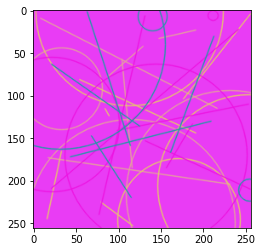

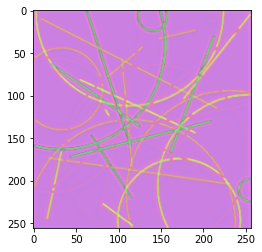

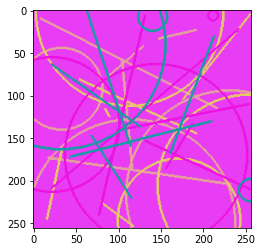

In [16]:
torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, Path("last_model.pt"))

with torch.no_grad():
    input, labels, _ = next(iter(train_dataloader))
    net_cpu = net.to(torch.device('cpu'))
    output = net_cpu(input)
    #clear_output(wait=True)
    plt.figure()
    plt.imshow (to_denormalized_PIL(input[0]))
    plt.figure()
    plt.imshow (to_denormalized_PIL(output[0]))
    plt.figure()
    plt.imshow (to_denormalized_PIL(labels[0]))